<h3>10.4 微调实例</h3>

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from datetime import datetime

In [15]:
trans_train = transforms.Compose(
    [transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
     transforms.RandomRotation(degrees=15),
     transforms.ColorJitter(),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),     
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trans_valid = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=trans_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=trans_valid)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


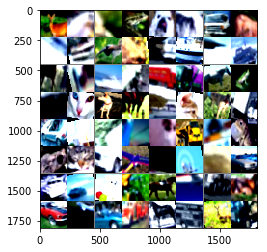

 deer horse  bird  frog


In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()


# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
images.shape

torch.Size([64, 3, 224, 224])

In [5]:
#models.resnet18

In [17]:
# 使用预训练的模型
net = models.resnet18(pretrained=True)
#print(net)

In [18]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [19]:
# 将最后的全连接层改成十分类
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.fc = nn.Linear(512, 10)
#net = torch.nn.DataParallel(net)
net.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [20]:
# 打出第一层的权重
print(net.conv1.weight.type())

torch.cuda.FloatTensor


In [21]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-3,momentum=0.9)

In [23]:
def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
   
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            im = im.to(device)  # (bs, 3, h, w)
            label = label.to(device) # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                im = im.to(device)  # (bs, 3, h, w)
                label = label.to(device) # (bs, h, w)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [25]:
train(net, trainloader, testloader, 20, optimizer, criterion)